# Show, attend and tell

"Show, attend and tell" is an image captioning encoder-decoder-architecture using an Attention mechanism in the decoding.
Code from: https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Image-Captioning

In [2]:
from IPython.core.display import display, HTML, Image
display(HTML("<style>.container { width:100% !important; }</style>"))

## Basic Encoder-Decoder





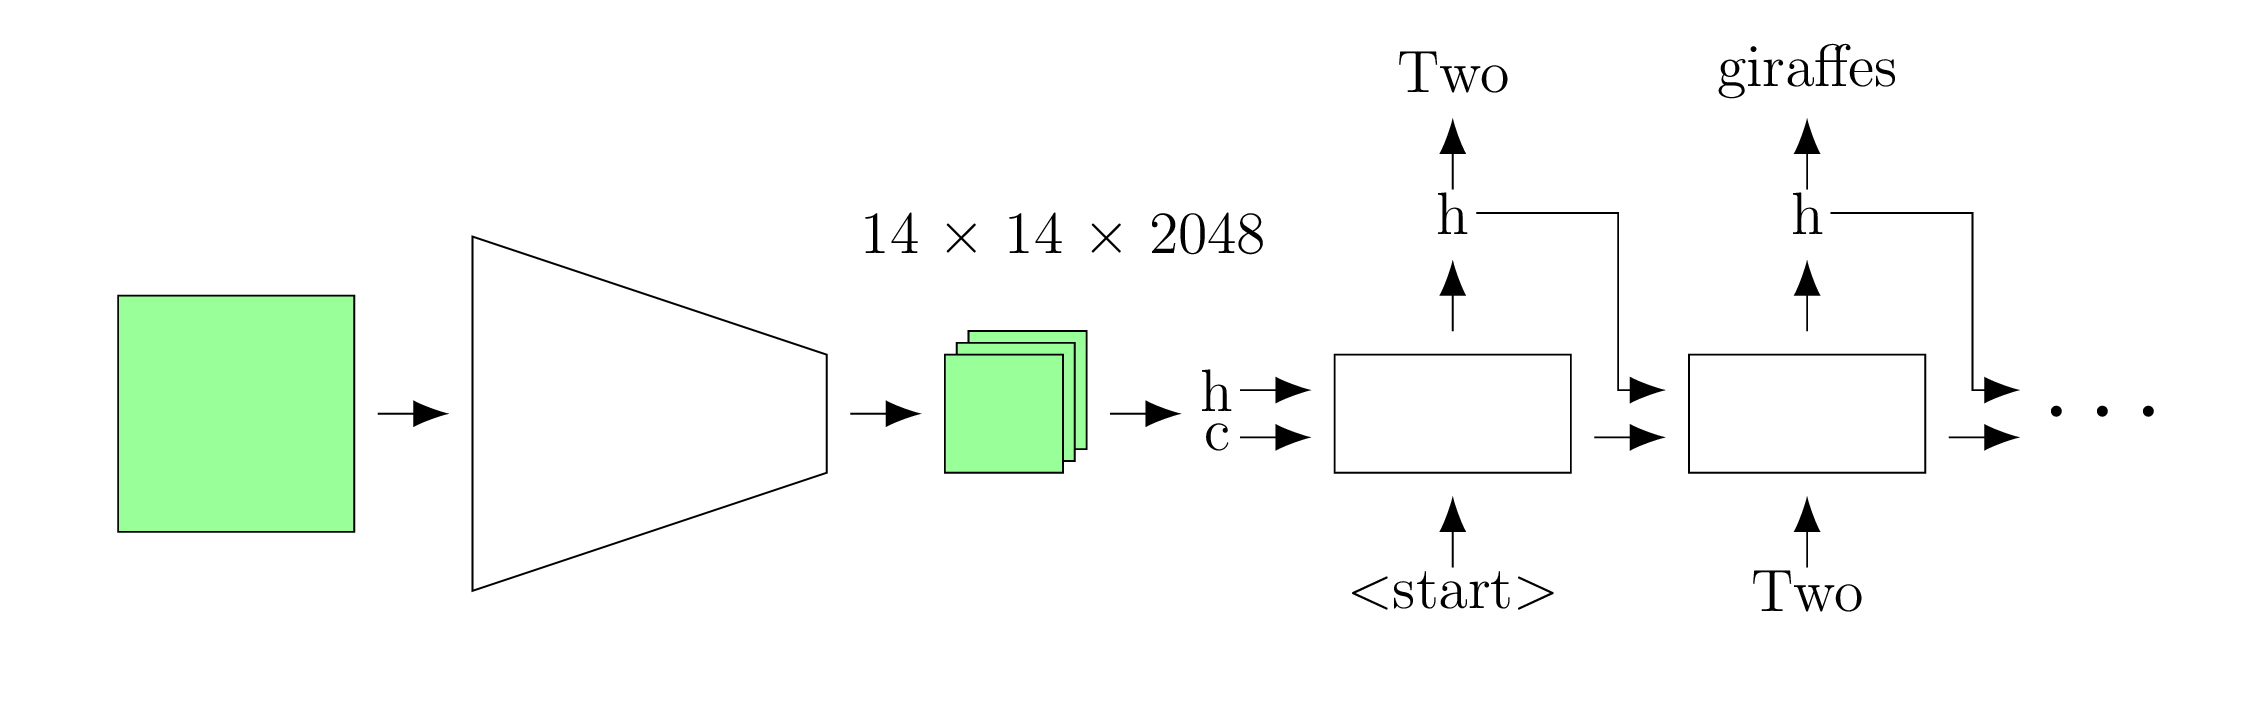

In [43]:
Image("images/enc_dec.png")

One problem: the image information at each timestep is the same.

An example of an encoded image feature (one of the 2048 14 * 14 patches):

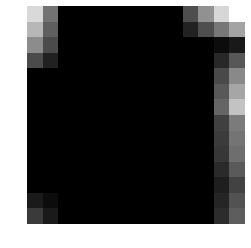

In [44]:
Image("img_feature.png")

## Attention
Idea: At each timestep, focus on different part of the image.

For each pixel of the 14 * 14 image features, calculate a weight, such that $\sum_p \alpha_p = 1$ (soft attention). Then we calculate the weighted image features: $\sum_p \alpha_p * a_p$. In the next step, the LSTM-cell is fed the weighted image representation in addition to the previous word.

An example of attention weights:

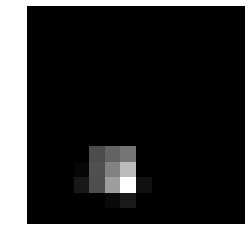

In [45]:
Image("images/att_small.png")

How is the attention calculated?

$a$ - image features produced by encoder

$h_{t-1}$ - previous hidden state

$\alpha$ - attention weights

$z$ - weighted image encodings

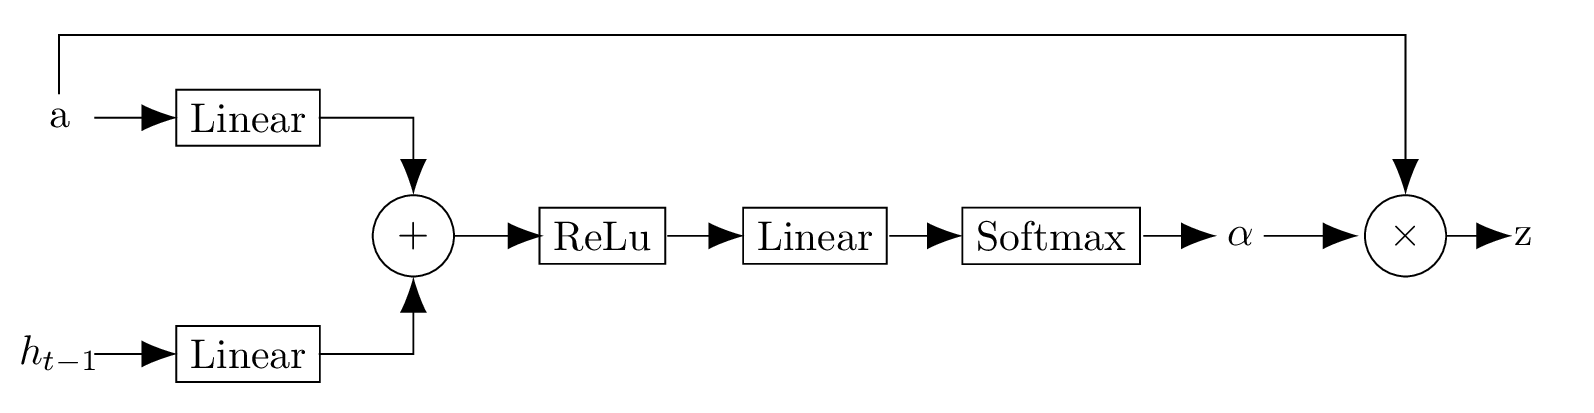

In [56]:
Image("images/att_net.png")

The complete network then looks like this:

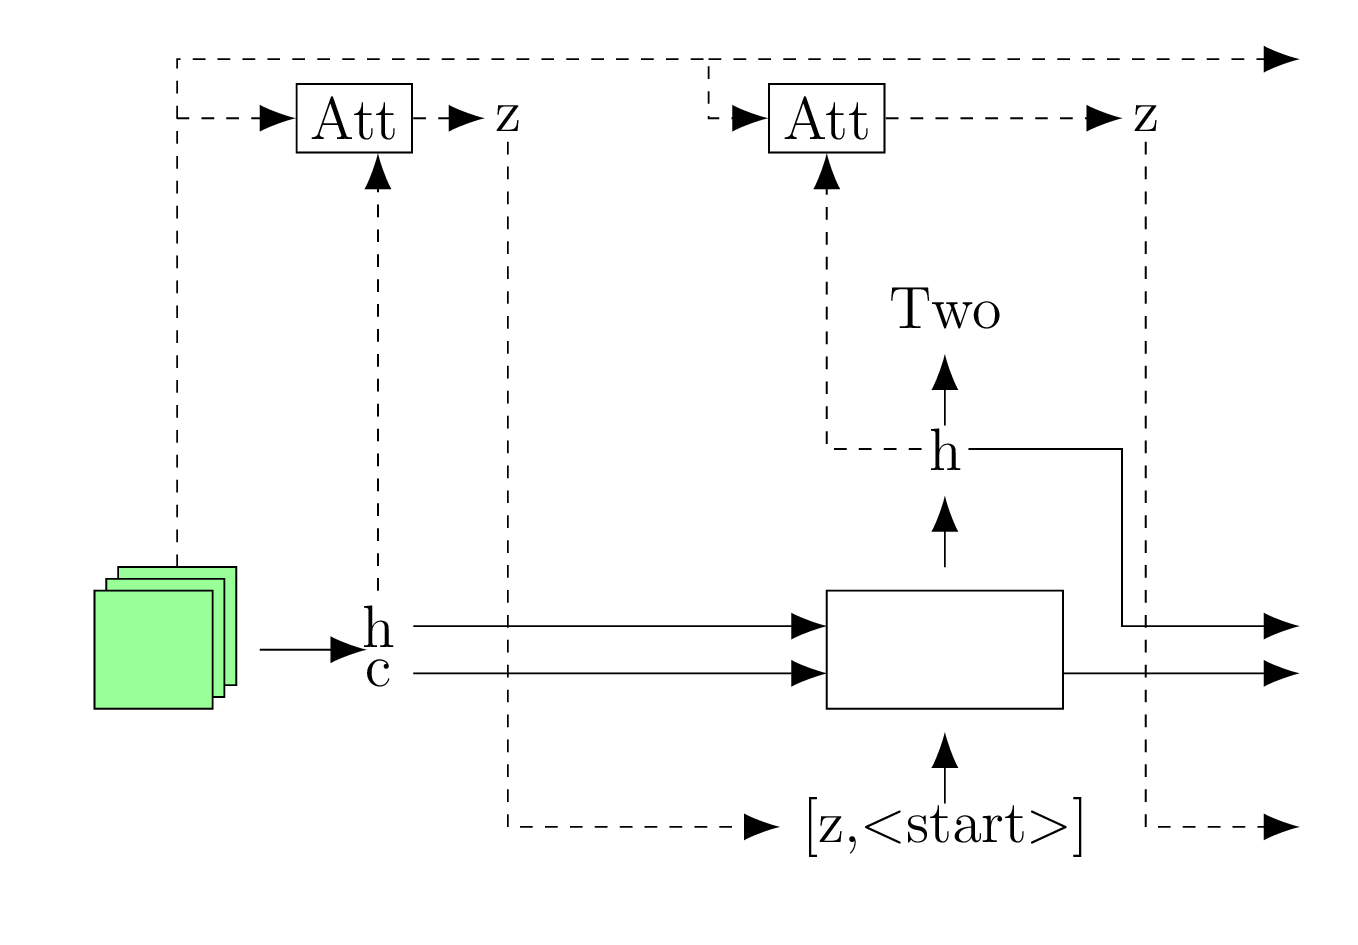

In [3]:
Image("images/full_net.png")

## Code

### Model

In [ ]:
class Encoder(nn.Module):
    def forward(self, images):
        out = self.resnet(images)
        out = self.adaptive_pool(out)
        out = out.permute(0, 2, 3, 1)
        return out

In [ ]:
class Attention(nn.Module):
    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)
        alpha = self.softmax(att)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)

        return attention_weighted_encoding, alpha

In [ ]:
class DecoderWithAttention(nn.Module):
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        ...

        # Embedding
        embeddings = self.embedding(encoded_captions)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)
        ...

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels)

        for t in range(max(decode_lengths)):
            ... 
            awe, alpha = self.attention(encoder_out[:batch_size_t],
                                        h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))
            awe = gate * awe
      
        h, c = self.decode_step(
            # input: embedding of previous word, weighted image encoding
            torch.cat([embeddings[:batch_size_t, t, :], awe], dim=1),
            # hidden state and cell state
            (h[:batch_size_t], c[:batch_size_t]))
      
        preds = self.fc(self.dropout(h))
        predictions[:batch_size_t, t, :] = preds
        alphas[:batch_size_t, t, :] = alpha

    return predictions, encoded_captions, decode_lengths, alphas, sort_ind

The next cell contains the same class as above, but I didn't remove the parts that deal with mini-batches. The forward pass orders the batch according to caption length. Then, at each time step, it ignores the examples whose caption isn't long enough to reach to that time step.

In [ ]:
class DecoderWithAttention(nn.Module):
    def forward(self, encoder_out, encoded_captions, caption_lengths):
        batch_size = encoder_out.size(0)
        encoder_dim = encoder_out.size(-1)
        vocab_size = self.vocab_size

        # Flatten image
        encoder_out = encoder_out.view(batch_size, -1, encoder_dim)  # (batch_size, num_pixels, encoder_dim)
        num_pixels = encoder_out.size(1)

        # Sort input data by decreasing lengths; why? apparent below
        caption_lengths, sort_ind = caption_lengths.squeeze(1).sort(dim=0, descending=True)
        encoder_out = encoder_out[sort_ind]
        encoded_captions = encoded_captions[sort_ind]

        # Embedding
        embeddings = self.embedding(encoded_captions)  # (batch_size, max_caption_length, embed_dim)

        # Initialize LSTM state
        h, c = self.init_hidden_state(encoder_out)  # (batch_size, decoder_dim)

        # We won't decode at the <end> position, since we've finished generating as soon as we generate <end>
        # So, decoding lengths are actual lengths - 1
        decode_lengths = (caption_lengths - 1).tolist()

        # Create tensors to hold word predicion scores and alphas
        predictions = torch.zeros(batch_size, max(decode_lengths), vocab_size).to(device)
        alphas = torch.zeros(batch_size, max(decode_lengths), num_pixels).to(device)

        # At each time-step, decode by
        # attention-weighing the encoder's output based on the decoder's previous hidden state output
        # then generate a new word in the decoder with the previous word and the attention weighted encoding
        for t in range(max(decode_lengths)):
            # only continue with training examples whose captions have length >= t
            batch_size_t = sum([l > t for l in decode_lengths]) 
            attention_weighted_encoding, alpha = self.attention(encoder_out[:batch_size_t],
                                                                h[:batch_size_t])
            gate = self.sigmoid(self.f_beta(h[:batch_size_t]))  # gating scalar, (batch_size_t, encoder_dim)
            attention_weighted_encoding = gate * attention_weighted_encoding
            h, c = self.decode_step(
                torch.cat([embeddings[:batch_size_t, t, :], attention_weighted_encoding], dim=1),
                (h[:batch_size_t], c[:batch_size_t]))  # (batch_size_t, decoder_dim)
            preds = self.fc(self.dropout(h))  # (batch_size_t, vocab_size)
            predictions[:batch_size_t, t, :] = preds
            alphas[:batch_size_t, t, :] = alpha

        return predictions, encoded_captions, decode_lengths, alphas, sort_ind


### Training

In addition to the cross entropy, the loss function also includes a regularizer. The term alphas.sum(dim=1) is a sum of the same attention weight over time steps (e.g., the pixel in the upper left corner). The term (1 - alphas.sum(dim=1)) then means that, ideally, each position in the image should receive attention at some point in the decoding.

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
imgs = encoder(imgs)
scores, caps_sorted, decode_lengths, alphas, sort_ind = decoder(imgs, caps, caplens)

scores, _ = pack_padded_sequence(scores, decode_lengths, batch_first=True)
targets, _ = pack_padded_sequence(targets, decode_lengths, batch_first=True)

loss = criterion(scores, targets)
loss += alpha_c * ((1. - alphas.sum(dim=1)) ** 2).mean()

### Captioning

For inference, the program uses beam search. This is to find a compromise between generating one solution quickly and searching through all possible solutions.

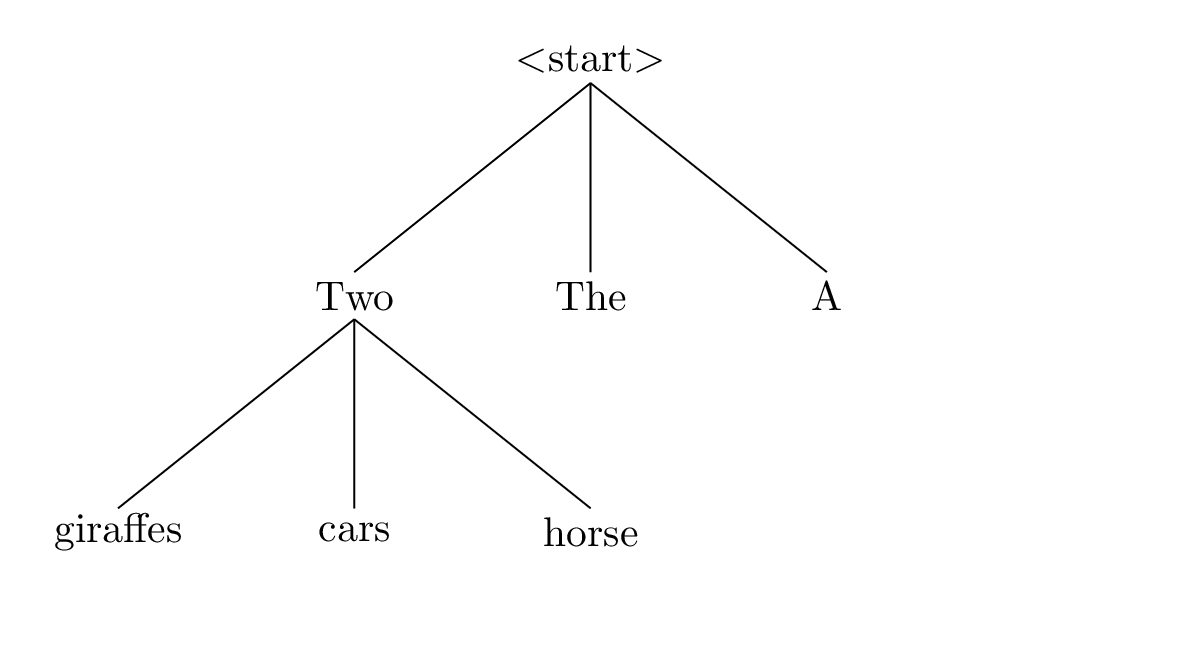

In [48]:
Image("images/beam_search.png")

In [ ]:
def caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size=3):
    k = beam_size
    vocab_size = len(word_map)

    # Read image and process
    img = imread(image_path)
    ... # image transformations
    image = transform(img)  # (3, 256, 256)

    # Encode
    image = image.unsqueeze(0)
    encoder_out = encoder(image)
    enc_image_size = encoder_out.size(1)
    encoder_dim = encoder_out.size(3)

    # Flatten encoding
    encoder_out = encoder_out.view(1, -1, encoder_dim)
    num_pixels = encoder_out.size(1)

    # We'll treat the problem as having a batch size of k
    encoder_out = encoder_out.expand(k, num_pixels, encoder_dim)
    k_prev_words = torch.LongTensor([[word_map['<start>']]] * k).to(device)
    seqs = k_prev_words
    top_k_scores = torch.zeros(k, 1).to(device)
    seqs_alpha = torch.ones(k, 1, enc_image_size, enc_image_size).to(device)

    # Lists to store completed sequences, their alphas and scores
    complete_seqs = list()
    complete_seqs_alpha = list()
    complete_seqs_scores = list()

    # Start decoding
    step = 1
    h, c = decoder.init_hidden_state(encoder_out)

    # s is a number less than or equal to k, because sequences are removed from this process once they hit <end>
    while True:

        embeddings = decoder.embedding(k_prev_words).squeeze(1)

        awe, alpha = decoder.attention(encoder_out, h)

        alpha = alpha.view(-1, enc_image_size, enc_image_size)

        gate = decoder.sigmoid(decoder.f_beta(h))
        awe = gate * awe
    
        h, c = decoder.decode_step(torch.cat([embeddings, awe], dim=1), (h, c))

        scores = decoder.fc(h)
        scores = F.log_softmax(scores, dim=1)

        # Add
        scores = top_k_scores.expand_as(scores) + scores

        # For the first step, all k points will have the same scores (since same k previous words, h, c)
        if step == 1:
            top_k_scores, top_k_words = scores[0].topk(k, 0, True, True)  # (s)
        else:
            top_k_scores, top_k_words = scores.view(-1).topk(k, 0, True, True)  # (s)
    
        prev_word_inds = top_k_words / vocab_size  # (s)
        # each part of scores.view(-1) belongs to one of the sequences
        next_word_inds = top_k_words % vocab_size  # (s)

        # Add new words to sequences, alphas
        seqs = torch.cat([seqs[prev_word_inds], next_word_inds.unsqueeze(1)], dim=1)  # (s, step+1)
        seqs_alpha = torch.cat([seqs_alpha[prev_word_inds], alpha[prev_word_inds].unsqueeze(1)],
                               dim=1)  # (s, step+1, enc_image_size, enc_image_size)

        # Which sequences are incomplete (didn't reach <end>)?
        incomplete_inds = [ind for ind, next_word in enumerate(next_word_inds) if
                           next_word != word_map['<end>']]
        complete_inds = list(set(range(len(next_word_inds))) - set(incomplete_inds))

        # Set aside complete sequences
        if len(complete_inds) > 0:
            complete_seqs.extend(seqs[complete_inds].tolist())
            ...
            k -= len(complete_inds)  # reduce beam length accordingly

        # Proceed with incomplete sequences
        if k == 0:
            break
        seqs = seqs[incomplete_inds]
        seqs_alpha = seqs_alpha[incomplete_inds]
        h = h[prev_word_inds[incomplete_inds]]
        c = c[prev_word_inds[incomplete_inds]]
        encoder_out = encoder_out[prev_word_inds[incomplete_inds]]
        top_k_scores = top_k_scores[incomplete_inds].unsqueeze(1)
        k_prev_words = next_word_inds[incomplete_inds].unsqueeze(1)

        # Break if things have been going on too long
        if step > 50:
            break
        step += 1

    i = complete_seqs_scores.index(max(complete_seqs_scores))
    seq = complete_seqs[i]
    alphas = complete_seqs_alpha[i]

    return seq, alphas


## The model in action

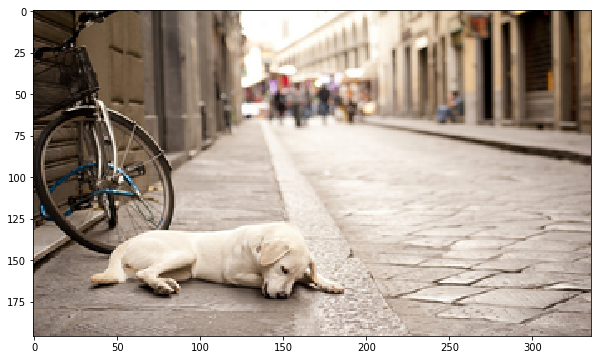

In [50]:
import torch
import json
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import skimage


from caption import caption_image_beam_search#, visualize_att
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'

model_path = "BEST_with_enc_fine_16_epochs.pth.tar"
wordmap_path = "../datafiles/WORDMAP_coco_5_cap_per_img_5_min_word_freq.json"
image_path = "../../../data/ImageCorpora/MSCOCO/val2014/COCO_val2014_000000000074.jpg"
beam_size = 5

image = Image.open(image_path)
image = image.resize([14*24, 14*14], Image.LANCZOS)

fig = plt.figure(figsize=(10,10))
plt.imshow(image)


In [51]:
#code from here on copied from repository
checkpoint = torch.load(model_path)
decoder = checkpoint['decoder']
decoder = decoder.to(device)
decoder.eval()
encoder = checkpoint['encoder']
encoder = encoder.to(device)
encoder.eval()

# Load word map (word2ix)
with open(wordmap_path, 'r') as j:
    word_map = json.load(j)
rev_word_map = {v: k for k, v in word_map.items()}  # ix2word

# Encode, decode with attention and beam search
seq, alphas = caption_image_beam_search(encoder, decoder, image_path, word_map, beam_size)
alphas = torch.FloatTensor(alphas)

words = [rev_word_map[ind] for ind in seq]
print(words)

['<start>', 'a', 'dog', 'laying', 'on', 'the', 'ground', 'next', 'to', 'a', 'bike', '<end>']


In [52]:
#copied from caption.py
def visualize_att(image_path, seq, alphas, rev_word_map, smooth=True):
    image = Image.open(image_path)
    image = image.resize([14 * 24, 14 * 24], Image.LANCZOS)

    words = [rev_word_map[ind] for ind in seq]
    
    fig = plt.figure(figsize=(40,40))

    for t in range(len(words)):
        if t > 50:
            break
        plt.subplot(np.ceil(len(words) / 5.), 5, t + 1)

        plt.text(0, 1, '%s' % (words[t]), color='black', backgroundcolor='white', fontsize=20)
        plt.imshow(image)
        current_alpha = alphas[t, :]
        if smooth:
            alpha = skimage.transform.pyramid_expand(current_alpha.numpy(), upscale=24, sigma=8)
        else:
            alpha = skimage.transform.resize(current_alpha.numpy(), [14 * 24, 14 * 24])
        if t == 0:
            plt.imshow(alpha, alpha=0)
        else:
            plt.imshow(alpha, alpha=0.8)
        plt.set_cmap(cm.Greys_r)
        plt.axis('off')
    plt.show()


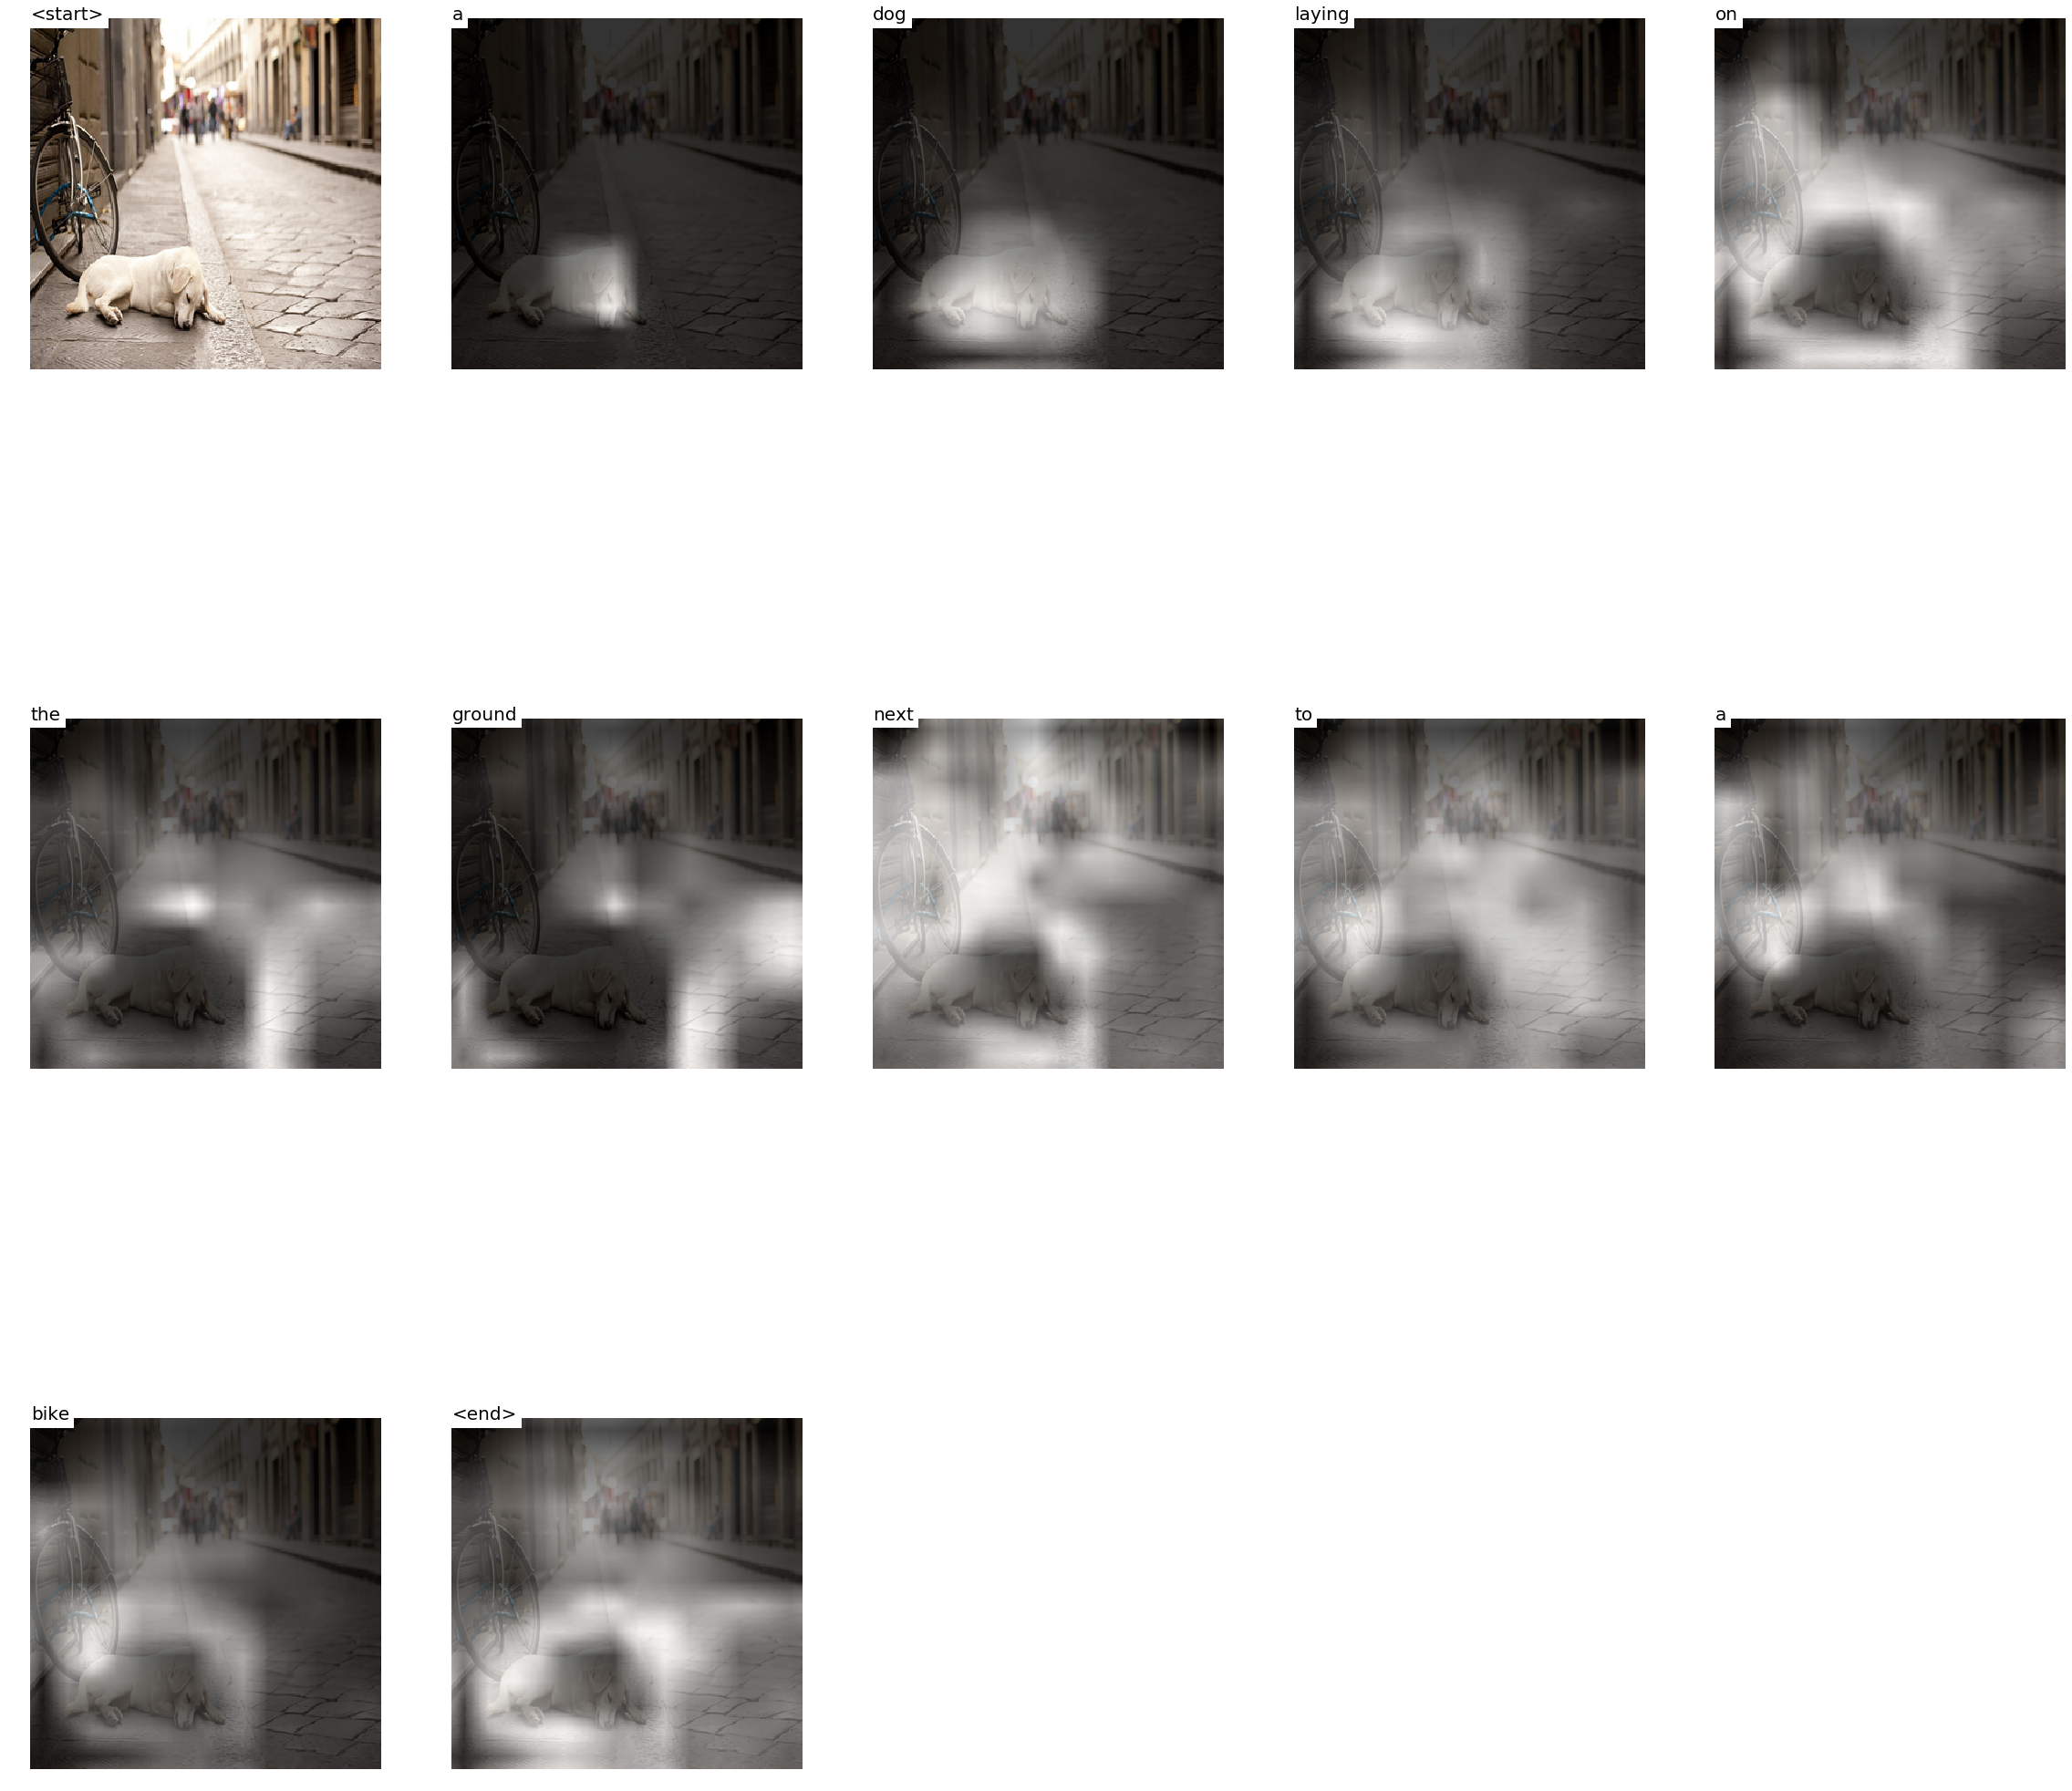

In [53]:
visualize_att(image_path, seq, alphas, rev_word_map, False)